In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize( (32,32) ),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform

def get_datasets(root='data', train=True, test=True, transform=None, batch=64):
    assert train or test, 'You must select train, test, or both'
    ret = {}
    transform = get_transform() if transform is None else transform
    if train:
        trainset = torchvision.datasets.CIFAR10(
            root=root, train=True, download=True, transform=transform
        )
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=batch, shuffle=True, num_workers=2
        )
        ret['train']   = trainloader
        ret['n_train'] = len(trainset)

    if test:
        testset = torchvision.datasets.CIFAR10(
            root=root, train=False, download=True, transform=transform
        )
        testloader = torch.utils.data.DataLoader(
            testset, batch_size=batch, shuffle=False, num_workers=2
        )
        ret['test']   = testloader
        ret['n_test'] = len(testset)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    ret['classes'] = classes

    return ret


In [ ]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetModel, self).__init__()

        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
model = ResNetModel(num_classes = 10)
datasets = get_datasets(test=False)

model_fn = "model_cifar_resnet.pth"

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

Files already downloaded and verified
cuda


In [ ]:
model = model.to(device)
max_epochs = 20
loss_history = []
for epoch in range(max_epochs):
  running_loss = 0.0
  with tqdm(datasets['train']) as tqdm_train:
    for i, data in enumerate(tqdm_train):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 200 == 199:
        tqdm_train.set_description('Epoch: {}/{} Loss: {:.3f}'.format(
          epoch+1, max_epochs, running_loss / 200.))
        loss_history.append(running_loss / 200.)
        running_loss = 0.0

print('Model trained.')
print('Saving the model to "{}"'.format(model_fn))

torch.save(model.state_dict(), model_fn)

Epoch: 20/20 Loss: 0.156: 100%|██████████| 782/782 [00:25<00:00, 30.98it/s]


Model trained.
Saving the model to "model_cifar_resnet.pth"


ResNet18 results below

In [ ]:
print(loss_history)

[2.622028719186783, 2.145177519917488, 2.001941232681274, 1.648298369050026, 1.515150476694107, 1.4306932216882706, 1.2651597988605499, 1.2028371199965477, 1.1354122430086135, 1.0212637582421302, 0.983672684431076, 0.981690416932106, 0.8679538106918335, 0.8646758434176445, 0.8669010543823242, 0.7707373805344104, 0.7784030844271183, 0.7706084632873536, 0.6955687317252159, 0.6909479066729546, 0.6978619958460331, 0.5820533856749535, 0.6237911778688431, 0.6434468092024326, 0.5281733091175557, 0.5664831334352494, 0.5406951721012593, 0.4554464681446552, 0.4844348780810833, 0.501890979334712, 0.3836412444710732, 0.41981980711221695, 0.44451664701104165, 0.3111648580804467, 0.3641292676329613, 0.38952721416950226, 0.2897470108419657, 0.3024945806711912, 0.32977831199765206, 0.2362223939411342, 0.2797609950974584, 0.2987268503755331, 0.20564822882413863, 0.23730759106576443, 0.2523967190273106, 0.1876349240913987, 0.2057360415533185, 0.2143971729464829, 0.14718589442782104, 0.1874338405393064, 

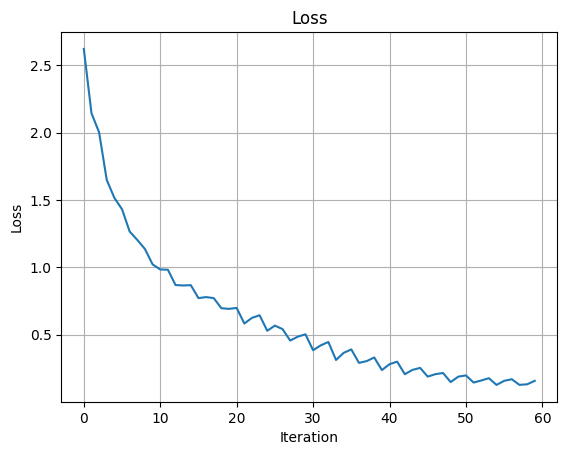

In [ ]:
plt.plot(loss_history)
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()